# Trabajo práctico N°1 - Modelo predictivo de tarifas de Uber

---
Aprendizaje Automático I

Tecnicatura Universitaria en Inteligencia Artificial

Facultad de Ciencias Exactas, Ingeniería y Agrimensura

Universidad Nacional de Rosario

2025

Estudiantes:

*   Facundo Geuna
*   Máximo Alva
*   Marco Ippolito

In [266]:
import pandas as pd
import numpy as np

import holidays
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic

## Carga de los datos

---

El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

In [267]:
!gdown 11_1K7dwm_ILD5nkQIC-DaaJPK2TChksx
df = pd.read_csv('uber_fares.csv')

Downloading...
From: https://drive.google.com/uc?id=11_1K7dwm_ILD5nkQIC-DaaJPK2TChksx
To: /content/uber_fares.csv
100% 23.5M/23.5M [00:00<00:00, 235MB/s]


In [268]:
df

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


## Análisis descriptivo de los datos

---

**Variables explicativas:**  
- **key**: variable numérica. Identificador único de cada viaje.
- **pickup_datetime**: variable de tipo datetime. Fecha y hora en que se inició el viaje.  
- **passenger_count**: variable numérica. Cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: variable numérica. Longitud del punto de inicio del viaje.  
- **pickup_latitude**: variable numérica. Latitud del punto de inicio del viaje.  
- **dropoff_longitude**: variable numérica. Longitud del punto de destino.  
- **dropoff_latitude**: variable numérica. Latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: variable numérica. Costo del viaje en dólares.

In [269]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [271]:
df = df.drop("key", axis=1)

### Variables 'date' y 'pickup_datetime'

In [272]:
# Pasamos la variable 'date' de tipo object a tipo datetime64
df["date"] = pd.to_datetime(df["date"])
# Quitamos los decimales a los segundos de la variable 'date' para mayor simplicidad
df["date"] = df["date"].dt.floor("s")
# Eliminamos la columna 'pickup_datetime' ya que contiene lo mismo que 'date' (La zona horaria no varía ya que son todos viajes en la misma ciudad)
df = df.drop('pickup_datetime', axis=1)

In [273]:
df.head()

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06,7.5,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56,7.7,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00,12.9,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21,5.3,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00,16.0,-73.925023,40.744085,-73.973082,40.761247,5


### Variable 'fare_amount'

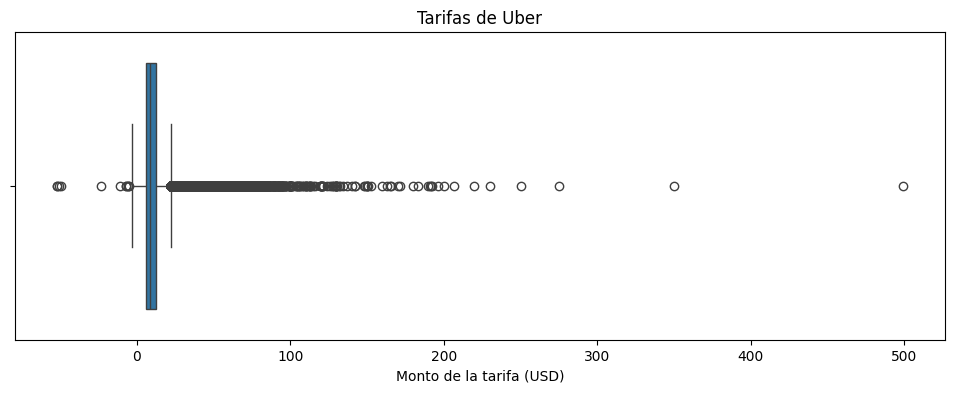

In [274]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='fare_amount')
plt.title("Tarifas de Uber")
plt.xlabel("Monto de la tarifa (USD)")
plt.show()

Tras graficar la distribución de la variable 'fare_amount' en un boxplot, observamos que existen algunas tarifas con valores negativos, lo cual no es posible para el monto de un viaje, este siempre debe ser un número mayor a cero.

Por lo tanto, tras verificar los registros donde esto sucede, procederemos a eliminarlos de nuestro dataset ya que no es conveniente realizar ninguna modificación en la variable objetivo.

In [275]:
# Chequeamos cuáles son las instancias que presentan valores negativos o cero en el monto del viaje
df[df['fare_amount'] <= 0]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
20744,2015-04-22 23:25:07,0.00,-73.658897,40.805199,-73.658897,40.805199,1
22182,2010-03-20 02:59:51,0.00,-73.994366,40.755395,-73.998718,40.854853,2
63395,2015-03-03 23:07:41,-5.00,-73.992249,40.748936,-73.988518,40.748180,1
71246,2010-02-11 21:47:10,-3.30,-73.952725,40.768235,-73.949928,40.772208,2
79903,2015-05-01 14:43:02,-3.50,-73.982430,40.775024,-73.981750,40.778439,1
87467,2015-01-04 03:51:13,0.00,-73.969475,40.807503,0.000000,0.000000,2
89322,2010-03-09 08:26:10,-49.57,-73.972772,40.785657,-73.972867,40.785500,5
92063,2010-03-12 08:49:10,-23.70,-73.952740,40.768233,-74.007028,40.707338,3
98875,2015-03-20 21:31:14,-52.00,-74.000359,40.728729,-74.005699,40.728680,5
104080,2010-03-09 20:25:10,-7.30,-73.952623,40.766942,-73.953787,40.784882,1


In [276]:
# Eliminamos los montos del viaje que son menores a cero
df = df[df['fare_amount'] >= 0]

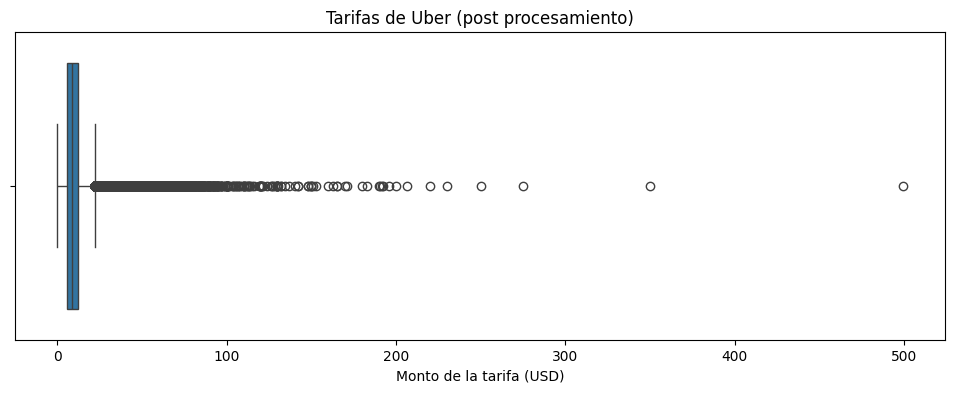

In [277]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='fare_amount')
plt.title("Tarifas de Uber (post procesamiento)")
plt.xlabel("Monto de la tarifa (USD)")
plt.show()

También, observamos algunos registros con valores outliers muy elevados, comprobaremos más adelante si corresponden a viajes entre ciudades o a errores en la entrada de datos.

### Variables 'pickup_longitude', 'pickup_latitude',	'dropoff_longitude' y	'dropoff_latitude'


In [278]:
df[df.isna().any(axis=1)]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,2013-07-02 03:51:57,24.1,-73.950581,40.779692,NaN,NaN,0


In [279]:
df = df.dropna()

Observamos que existe una fila que contiene datos faltantes en las variables 'dropoff_longitude' y 'dropoff_latitude'. Procedimos a eliminarla ya que estas variables serán importantes para nuestra predicción, ya que a partir de ellas podemos calcular la distancia del viaje. Al ser una sola fila, no será una pérdida significativa, además, no tenemos una forma confiable de imputarlas.

A continuación, realizamos un análisis para detectar longitudes y latitudes que están fuera del rango. Longitud: debe estar entre -180° y 180°. Latitud: debe estar entre -90° y 90°.

In [280]:
df[(df["pickup_longitude"] <= -180) | (df["pickup_longitude"] >= 180) |
   (df["dropoff_longitude"] <= -180) | (df["dropoff_longitude"] >= 180) |
   (df["pickup_latitude"] <= -90) | (df["pickup_latitude"] >= 90) |
   (df["dropoff_latitude"] <= -90) | (df["dropoff_latitude"] >= 90)]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4949,2012-04-28 00:58:00,4.9,-748.016667,40.739957,-74.003570,40.734192,1
32549,2012-06-16 10:04:00,15.7,-74.016055,40.715155,-737.916665,40.697862,2
48506,2011-11-05 23:26:00,33.7,-735.200000,40.770092,-73.980187,40.765530,1
56617,2012-03-11 07:24:00,8.1,-73.960828,404.433332,-73.988357,40.769037,1
61793,2012-06-13 05:45:00,8.5,-73.951385,401.066667,-73.982110,40.754117,1
75851,2011-11-05 00:22:00,15.7,-1340.648410,1644.421482,-3356.666300,872.697628,1
91422,2011-05-18 13:24:00,16.1,57.418457,1292.016128,1153.572603,-881.985513,1
103745,2011-10-14 19:04:00,12.9,-736.216667,40.767035,-73.982377,40.725562,1
139447,2012-01-20 11:50:00,13.7,-74.011042,40.709780,-73.983163,493.533332,4
144253,2009-08-26 11:55:00,7.3,-768.550000,40.757812,-73.997040,40.740007,1


Como podemos observar, solamente 12 instancias no cumplen con el rango permitido de valores de latitud y longitud.

In [281]:
df[(df["pickup_longitude"] == 0) | (df["dropoff_longitude"] == 0) | (df["pickup_latitude"] == 0) | (df["dropoff_latitude"] == 0)]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
7,2012-12-11 13:52:00,2.5,0.0,0.0,0.0,0.0,1
11,2011-05-23 22:15:00,8.5,0.0,0.0,0.0,0.0,1
65,2014-05-05 19:27:00,6.0,0.0,0.0,0.0,0.0,1
92,2011-12-02 14:07:00,6.1,0.0,0.0,0.0,0.0,1
120,2010-08-20 19:39:48,6.5,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...
199718,2011-08-19 07:16:00,4.9,0.0,0.0,0.0,0.0,1
199724,2013-10-11 11:25:41,7.5,0.0,0.0,0.0,0.0,1
199880,2014-02-22 06:45:46,6.5,0.0,0.0,0.0,0.0,1
199883,2012-09-10 17:39:00,12.5,0.0,0.0,0.0,0.0,2


Por último, podemos analizar que 3967 instancias tienen al menos un valor cero en alguna de las variables que indican longitud o latitud.

Teniendo en cuenta este análisis, luego del cálculo de la variable 'distance', optaremos por utilizar la Mediana como valor de imputación para dicha variable en los casos donde no contamos con coordenadas válidas.

### Variable 'passenger_count'

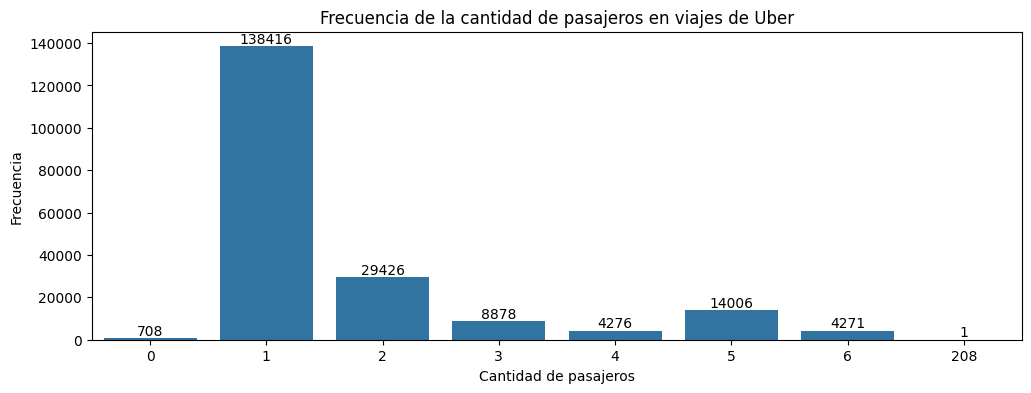

In [282]:
plt.figure(figsize=(12, 4))
ax = sns.countplot(x=df["passenger_count"])
ax.bar_label(ax.containers[0])
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de la cantidad de pasajeros en viajes de Uber")
plt.show()

Analizando el conteo de valores que asume la variable, observamos que existe un registro con 208 pasajeros, lo cual es físicamente imposible. Por otro lado, también detectamos 708 instancias con 0 pasajeros. Para estos casos, optamos por reemplazar estos valores por la moda (1), ya que es el valor que creemos más representativos del comportamiento habitual de los pasajeros.

In [283]:
moda = df["passenger_count"].mode()
moda = int(moda[0])
df.loc[df["passenger_count"] == 0, "passenger_count"] = moda
df.loc[df["passenger_count"] == 208, "passenger_count"] = moda

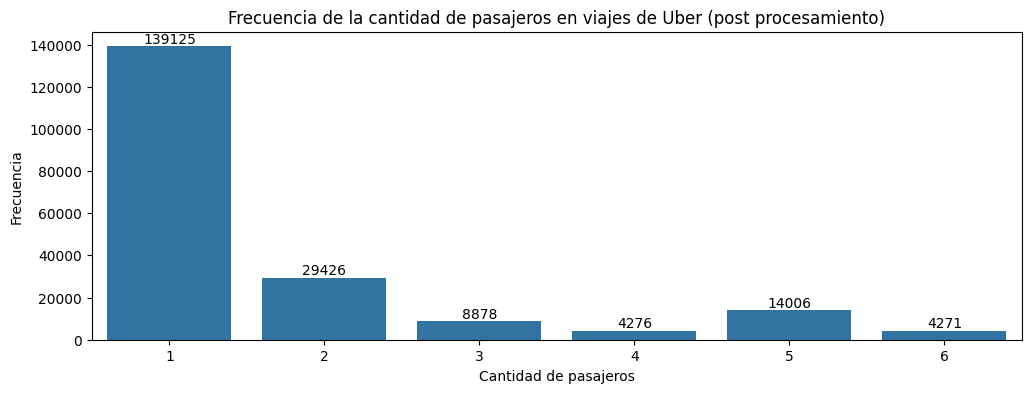

In [284]:
plt.figure(figsize=(12, 4))
ax = sns.countplot(x=df["passenger_count"])
ax.bar_label(ax.containers[0])
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de la cantidad de pasajeros en viajes de Uber (post procesamiento)")
plt.show()

### Nueva variable 'distance'

Para el caso de las latitudes y longitudes, se optó por agregar una nueva variable 'distance', la cual presenta la distancia en kilómetros entre las coordenadas de partida y de llegada, calculada utilizando la función geodesic de la librería geopy.

In [285]:
# Se hacen validaciones para detectar que una coordena geográfica sea válida.
# También se analiza que las coordenadas pertenezcan a la ciudad de Nueva York.

# Coordenadas aproximadas de Nueva York:
# Latitud: entre 40.4774 y 40.9176
# Longitud: entre -74.2591 y -73.7004

def calcular_distancia(row):
  if (pd.isna(row["pickup_latitude"]) or pd.isna(row["pickup_longitude"]) or
        pd.isna(row["dropoff_latitude"]) or pd.isna(row["dropoff_longitude"]) or
        row["pickup_longitude"] < -74.2591 or row["pickup_longitude"] > -73.7004 or
        row["dropoff_longitude"] < -74.2591 or row["dropoff_longitude"] > -73.7004 or
        row["pickup_latitude"] < 40.4774 or row["pickup_latitude"] > 40.9176 or
        row["dropoff_latitude"] < 40.4774 or row["dropoff_latitude"] > 40.9176 or
        row["pickup_longitude"] == 0 or row["dropoff_longitude"] == 0 or
        row["pickup_latitude"] == 0 or row["dropoff_latitude"] == 0):
        return np.nan  #retornar nan si las coordenadas son inválidas

  #distancia si las coordenadas son válidas
  return geodesic(
      (row["pickup_latitude"], row["pickup_longitude"]),
      (row["dropoff_latitude"], row["dropoff_longitude"])).km

#función a cada fila del dataframe
df['distance'] = df.apply(calcular_distancia, axis=1)

In [286]:
df.head()

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2015-05-07 19:52:06,7.5,-73.999817,40.738354,-73.999512,40.723217,1,1.681111
1,2009-07-17 20:04:56,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2.454363
2,2009-08-24 21:45:00,12.9,-74.005043,40.740770,-73.962565,40.772647,1,5.039603
3,2009-06-26 08:22:21,5.3,-73.976124,40.790844,-73.965316,40.803349,3,1.661442
4,2014-08-28 17:47:00,16.0,-73.925023,40.744085,-73.973082,40.761247,5,4.483730


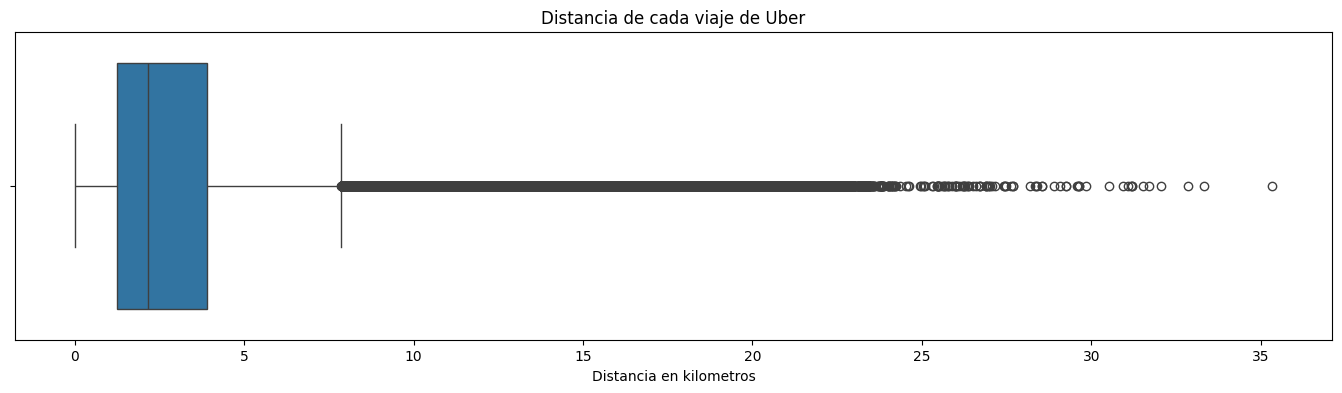

In [287]:
plt.figure(figsize=(17,4))
sns.boxplot(x=df["distance"])
plt.xlabel("Distancia en kilometros")
plt.title("Distancia de cada viaje de Uber")
plt.show()

In [288]:
df[df["distance"].isna()]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
7,2012-12-11 13:52:00,2.5,0.0,0.000000,0.000000,0.000000,1,NaN
11,2011-05-23 22:15:00,8.5,0.0,0.000000,0.000000,0.000000,1,NaN
65,2014-05-05 19:27:00,6.0,0.0,0.000000,0.000000,0.000000,1,NaN
92,2011-12-02 14:07:00,6.1,0.0,0.000000,0.000000,0.000000,1,NaN
120,2010-08-20 19:39:48,6.5,0.0,0.000000,0.000000,0.000000,1,NaN
...,...,...,...,...,...,...,...,...
199724,2013-10-11 11:25:41,7.5,0.0,0.000000,0.000000,0.000000,1,NaN
199880,2014-02-22 06:45:46,6.5,0.0,0.000000,0.000000,0.000000,1,NaN
199883,2012-09-10 17:39:00,12.5,0.0,0.000000,0.000000,0.000000,2,NaN
199936,2012-07-21 16:19:00,4.1,-736.4,40.774307,-73.982215,40.769672,5,NaN


In [289]:
df[df["distance"] == 0]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
5,2011-02-12 02:27:09,4.90,-73.969019,40.755910,-73.969019,40.755910,1,0.0
48,2013-01-03 22:24:41,56.80,-73.993498,40.764686,-73.993498,40.764686,1,0.0
84,2009-08-07 10:43:07,49.57,-73.975058,40.788820,-73.975058,40.788820,1,0.0
166,2014-01-22 21:01:18,4.50,-73.992937,40.757780,-73.992937,40.757780,1,0.0
361,2009-08-24 17:25:00,10.10,-73.928705,40.753475,-73.928705,40.753475,1,0.0
...,...,...,...,...,...,...,...,...
199448,2010-07-24 21:16:00,5.70,-73.924907,40.745833,-73.924907,40.745833,3,0.0
199612,2013-02-17 11:27:00,4.50,-73.969717,40.765832,-73.969717,40.765832,3,0.0
199647,2009-06-07 02:07:26,2.50,-73.956623,40.771633,-73.956623,40.771633,1,0.0
199917,2013-06-24 22:17:43,4.50,-73.793768,40.656939,-73.793768,40.656939,1,0.0


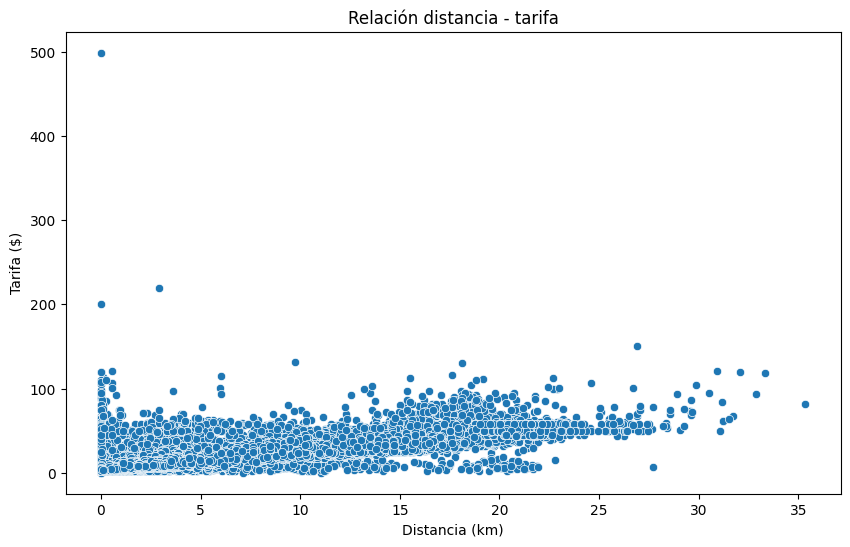

In [290]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['distance'], y=df['fare_amount'])
plt.xlabel('Distancia (km)')
plt.ylabel('Tarifa ($)')
plt.title('Relación distancia - tarifa')
plt.show()

Observamos algunas relaciones entre tarifa y distancia que consideramos errores de entrada de datos, existen viajes muy cortos con tarifas exorbitantes que solo empeoraran nuestros modelos. Procederemos a eliminarlos.

In [291]:
# Eliminamos los montos del viaje mayores o iguales a 190
df = df[df['fare_amount'] <= 190]

### Nuevas variables 'uber_xl', 'hour', 'month', 'year', 'weekend' y 'holiday'

Decidimos agregar una variable categórica binaria 'uber_xl' para diferenciar dos tipos de viajes distintos según la cantidad de pasajeros.


*   Si el viaje lleva entre 1 y 4 pasajeros --> 0
*   Si el viaje lleva 5 o 6 pasajeros --> 1

In [292]:
df["uber_xl"] = df["passenger_count"].apply(lambda x: 1 if 5 <= x <= 6 else 0)

Agregamos también las variables numérica 'year', 'month' y 'hour' que extraen de 'date' año, mes y hora, respectivamente.

In [293]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour

Creamos la variable categórica binaria 'weekend' que determina si el viaje sucedió un fin de semana o no.

*   Lunes, martes, miércoles, jueves, viernes --> 1
*   Sábado, domingo --> 1



In [294]:
df['weekend'] = df['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

Por último, añadimos la variable categórica binaria 'holiday' que determina si el viaje fue realizado un día feriado o no. Tuvimos en cuenta feriados específicos del estado de New York.

*   Día no feriado --> 0
*   Día feriado --> 1



In [295]:
# Feriados del estado de New York
feriados_ny = holidays.US(state='NY', years=2025)

df['holiday'] = df['date'].dt.date.apply(lambda x: 1 if x in feriados_ny else 0)

In [296]:
df.head()

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,uber_xl,year,month,hour,weekend,holiday
0,2015-05-07 19:52:06,7.5,-73.999817,40.738354,-73.999512,40.723217,1,1.681111,0,2015,5,19,0,0
1,2009-07-17 20:04:56,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2.454363,0,2009,7,20,0,0
2,2009-08-24 21:45:00,12.9,-74.005043,40.740770,-73.962565,40.772647,1,5.039603,0,2009,8,21,0,0
3,2009-06-26 08:22:21,5.3,-73.976124,40.790844,-73.965316,40.803349,3,1.661442,0,2009,6,8,0,0
4,2014-08-28 17:47:00,16.0,-73.925023,40.744085,-73.973082,40.761247,5,4.483730,1,2014,8,17,0,0


### Visualización de Datos

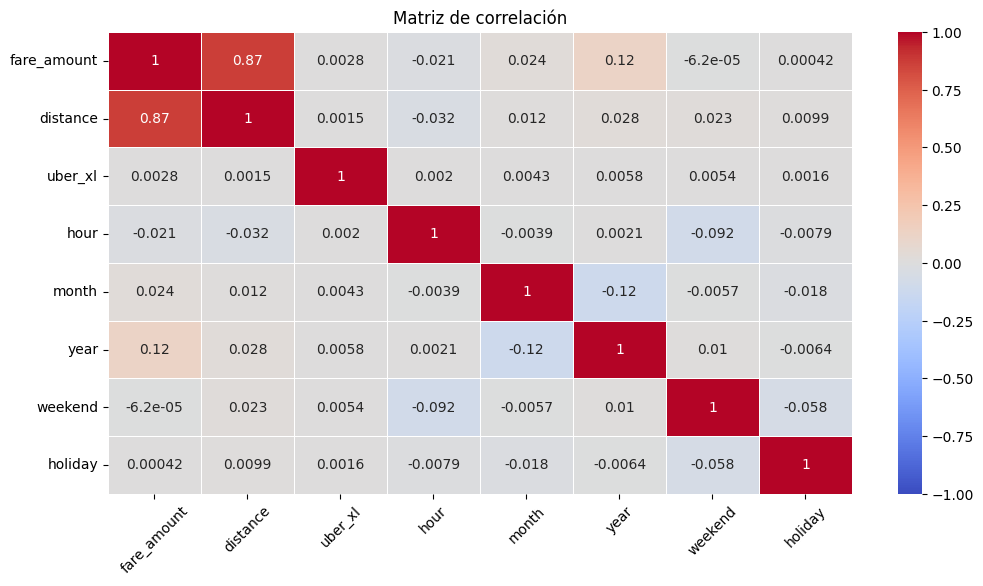

In [297]:
corr = df[['fare_amount', 'distance', 'uber_xl', 'hour', 'month', 'year', 'weekend', 'holiday']].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='coolwarm')
plt.title("Matriz de correlación"), plt.xticks(rotation=45)
plt.show()

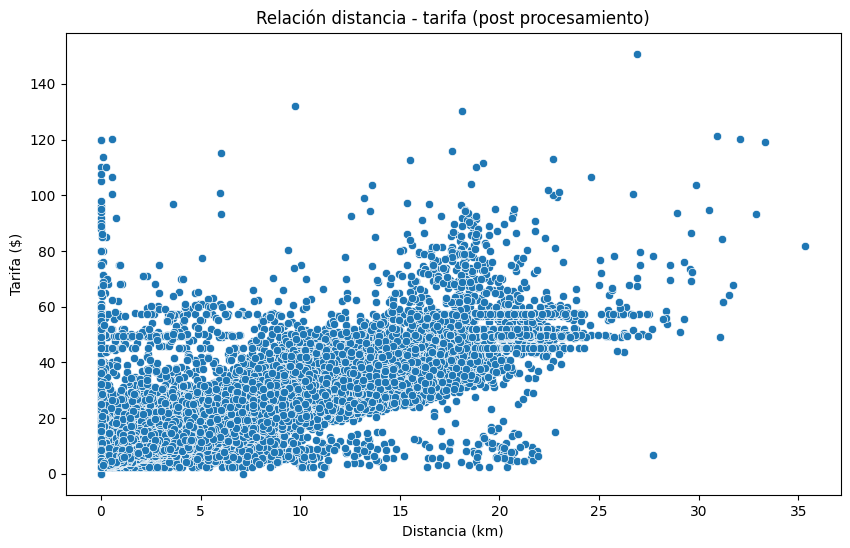

In [298]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['distance'], y=df['fare_amount'])
plt.xlabel('Distancia (km)')
plt.ylabel('Tarifa ($)')
plt.title('Relación distancia - tarifa (post procesamiento)')
plt.show()

## División del dataset en conjuntos de entrenamiento y prueba

In [299]:
X = df.drop(['fare_amount', 'date', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1)
y = df['fare_amount']

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Imputación de datos

In [301]:
# Calcular la mediana de 'distance' solo con los datos del set de entrenamiento
mediana = X_train['distance'].median()
print(mediana)
# Imputar en ambos sets
X_train['distance'] = X_train['distance'].fillna(mediana)
X_train.loc[X_train["distance"] == 0, "distance"] = mediana
X_test['distance'] = X_test['distance'].fillna(mediana)
X_test.loc[X_test["distance"] == 0, "distance"] = mediana

2.155482019648574


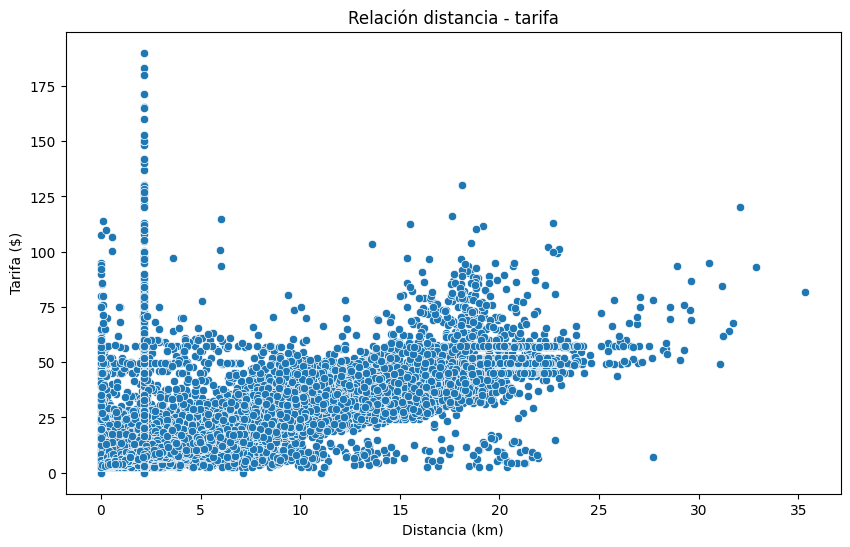

In [302]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train['distance'], y=y_train)
plt.xlabel('Distancia (km)')
plt.ylabel('Tarifa ($)')
plt.title('Relación distancia - tarifa')
plt.show()

Calculamos la mediana usando únicamente los datos del set de entrenamiento para no  filtrar información "futura" del set de test al modelo. Si calculasemos la mediana utilizando todo el dataset (entrenamiento + test) estaríamos obteniendo falsos buenos resultados o sobreajuste.

## Escalado de datos

In [391]:
scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Escalamos solamente 'distance' ya que es la única variable númerica continua de nuestro  dataset.

## Regresion Lineal

Realizamos dos modelos de regresión lineal para comparar resultados. Uno utilizando únicamente la variable 'distance' ya que es la que tiene la correlaciónmás alta con 'fare_amount' y otro utilizando todas las variables.



In [387]:
# Modelo 1 --> solamente 'distance'
lr1 = LinearRegression()
lr1.fit(X_train[['distance']], y_train)

# Predicciones
y_train_pred1 = lr1.predict(X_train[['distance']])
y_test_pred1 = lr1.predict(X_test[['distance']])

# Métricas
r2_lineal_train1 = r2_score(y_train, y_train_pred1)
r2_lineal_test1 = r2_score(y_test, y_test_pred1)
rmse_lineal_train1 = np.sqrt(mean_squared_error(y_train, y_train_pred1))
rmse_lineal_test1 = np.sqrt(mean_squared_error(y_test, y_test_pred1))

# Coeficientes
coeficientes_distance = pd.DataFrame({"feature": X_train[['distance']].columns, "coeficiente": lr1.coef_})
coeficientes_distance.sort_values(by="coeficiente", ascending=False)

,feature,coeficiente
0,distance,8.133596


In [388]:
# Modelo 2 --> todas las variables
lr2 = LinearRegression()
lr2.fit(X_train, y_train)

# Predicciones
y_train_pred2 = lr2.predict(X_train)
y_test_pred2 = lr2.predict(X_test)

# Métricas
r2_lineal_train2 = r2_score(y_train, y_train_pred2)
r2_lineal_test2 = r2_score(y_test, y_test_pred2)
rmse_lineal_train2 = np.sqrt(mean_squared_error(y_train, y_train_pred2))
rmse_lineal_test2 = np.sqrt(mean_squared_error(y_test, y_test_pred2))

# Coeficientes
coeficientes = pd.DataFrame({"feature": X_train.columns, "coeficiente": lr2.coef_})
coeficientes.sort_values(by="coeficiente", ascending=False)

,feature,coeficiente
1,distance,8.112133
3,year,0.977418
4,month,0.245034
0,passenger_count,0.102082
5,hour,0.041459
2,uber_xl,-0.080517
7,holiday,-0.082671
6,weekend,-0.191313


In [389]:
# Comparación de métricas
metricas = pd.DataFrame({
    "R² (train)": [r2_lineal_train1, r2_lineal_train2],
    "RMSE (train)": [rmse_lineal_train1, rmse_lineal_train2],
    "R² (test)": [r2_lineal_test1, r2_lineal_test2],
    "RMSE (test)": [rmse_lineal_test1, rmse_lineal_test2]
}, index=["Modelo 1 (distance)", "Modelo 2"]).T.round(4)
metricas

,Modelo 1 (distance),Modelo 2
R² (train),0.7052,0.7159
RMSE (train),5.2584,5.1621
R² (test),0.7014,0.7129
RMSE (test),5.3307,5.2270


In [307]:
# Comparación prediciones vs reales
resultados = pd.DataFrame({
    'Reales': y_test,
    'Modelo 1 (distance)': y_test_pred1,
    'Modelo 2': y_test_pred2
})
resultados

,Reales,Modelo 1 (distance),Modelo 2
121829,6.9,8.294357,7.746562
89141,7.7,6.865148,7.033316
195338,17.5,16.405464,18.136713
17775,6.5,6.882162,6.255918
809,6.0,7.779687,7.983818
...,...,...,...
26978,6.0,7.365670,9.243879
170036,12.0,7.359224,8.612660
45944,15.0,13.683944,14.266500
4252,8.5,6.563654,5.220087


Aunque distance sea la variable de mejor correlación, el modelo trata de minimizar el error total (RMSE). Entonces si al incluir las demas variables explicativas el error baja un poco, entonces el modelo las vamos a usar.

Por lo tanto concluímos que el modelo 2 es levemente mejor por que tiene un R² más alto tanto en entrenamiento como en test y tiene un RMSE(error promedio de predicción) más bajo.

Hemos calculado las métricas R² y RMSE tanto para el conjunto de entrenamiento como para el conjunto de prueba.

Lo hicimos asi porque el conjunto de entrenamiento nos dice qué tan bien el modelo aprendió los datos con los que se entrenó y el conjunto de prueba nos muestra qué tan bien el modelo generaliza a nuevos datos que nunca vio.

Si un modelo tiene muy buen rendimiento en entrenamiento pero mal en prueba, significa que está sobreajustado (overfitting).
Si ambos resultados son malos, es porque está subajustado (underfitting).

El modelo con mayor R² fue el de regresión lineal múltiple utilizando todas las variables, alcanzando valores cercanos a 0.72 en test, lo que indica una buena capacidad de explicación de la variable fare_amount.

El RMSE en test rondó los 5.0, lo que es razonable dado el rango de tarifas en el dataset(esto significa que el modelo se equivoca en promedio unos 5 dólares al predecir la tarifa de un viaje)

Además, al comparar los errores entre train y test, no se detectaron grandes diferencias, lo cual indica que el modelo no está sobreajustado y logra generalizar bien.

Por eso, consideramos que se ha conseguido un buen fitting en este conjunto de datos.


## Gradiente Descendiente

In [392]:
# Separamos el conjunto de datos para poder hacer una optimizacion de hiperparámetros
X_train_grad, X_val_grad, y_train_grad, y_val_grad = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [393]:
X_train_grad = X_train_grad.to_numpy().reshape(-1, 1)
X_val_grad = X_val_grad.to_numpy().reshape(-1, 1)
y_train_grad = y_train_grad.to_numpy().reshape(-1, 1)
y_val_grad = y_val_grad.to_numpy().reshape(-1, 1)

In [394]:
# División del conjunto de entrenamiento para validación
X_train_grad, X_val_grad, y_train_grad, y_val_grad = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

# Asegurarse de que son arrays 2D
X_train_grad = X_train_grad.to_numpy().reshape(-1, X_train_grad.shape[1])
X_val_grad = X_val_grad.to_numpy().reshape(-1, X_val_grad.shape[1])
y_train_grad = y_train_grad.to_numpy().reshape(-1, 1)
y_val_grad = y_val_grad.to_numpy().reshape(-1, 1)

In [395]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

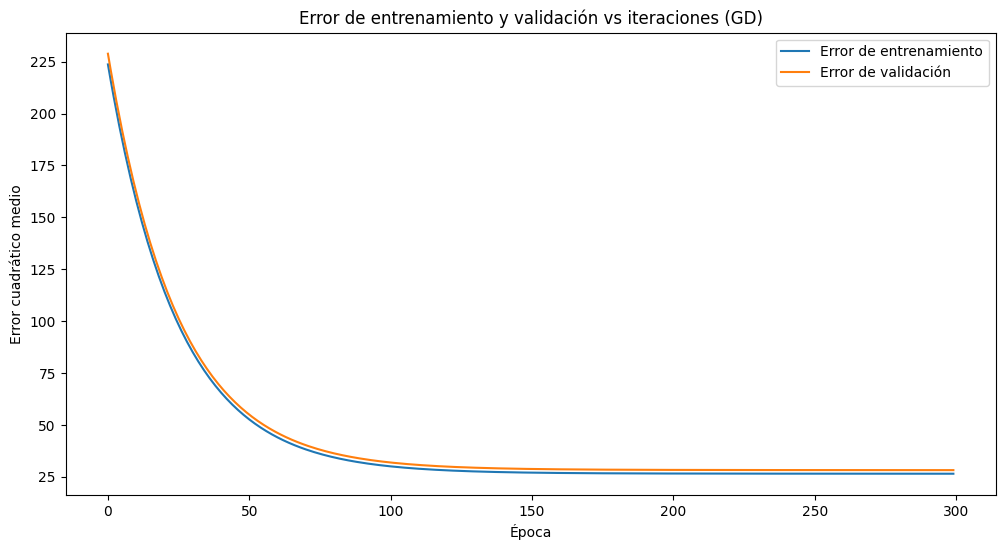

In [398]:
# Entrenamos el modelo
W_gd = gradient_descent(X_train_grad, y_train_grad, X_val_grad, y_val_grad, lr=0.01, epochs=300)

In [399]:
# Agregar columna de unos a X_train y X_val para predicción
X_train_full = np.hstack((np.ones((X_train_grad.shape[0], 1)), X_train_grad))
X_val_full = np.hstack((np.ones((X_val_grad.shape[0], 1)), X_val_grad))

# Predicciones
y_train_pred_gd = np.matmul(X_train_full, W_gd)
y_val_pred_gd = np.matmul(X_val_full, W_gd)

# Métricas
r2_train_gd = r2_score(y_train_grad, y_train_pred_gd)
r2_val_gd = r2_score(y_val_grad, y_val_pred_gd)
rmse_train_gd = np.sqrt(mean_squared_error(y_train_grad, y_train_pred_gd))
rmse_val_gd = np.sqrt(mean_squared_error(y_val_grad, y_val_pred_gd))

print(f"R² (train): {r2_train_gd:.4f} \tRMSE (train): {rmse_train_gd:.4f}")
print(f"R² (val)  : {r2_val_gd:.4f} \tRMSE (val)  : {rmse_val_gd:.4f}")

R² (train): 0.7161 	RMSE (train): 5.1455
R² (val)  : 0.7113 	RMSE (val)  : 5.3113


## Gradiente Descendiente Estocástico


In [400]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    # Agregar columna de 1s para el término independiente
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors_epoch = []
    test_errors_epoch = []

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        epoch_train_error = 0

        for j in range(n):
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction

            gradient = -2 * error * x_sample.T.reshape(-1, 1)
            W = W - (lr * gradient)

            epoch_train_error += error**2

        # Error medio en entrenamiento al final de cada epoch
        train_errors_epoch.append(epoch_train_error / n)

        # Error medio en test al final de cada epoch
        predictions_test = np.matmul(X_test, W)
        error_test = y_test - predictions_test
        test_mse = np.mean(error_test ** 2)
        test_errors_epoch.append(test_mse)

    # Gráfico final
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), train_errors_epoch, label='Error de entrenamiento')
    plt.plot(range(1, epochs + 1), test_errors_epoch, label='Error de prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Error cuadrático medio (MSE)')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs Épocas (SGD)')
    plt.grid(True)
    plt.show()

    return W

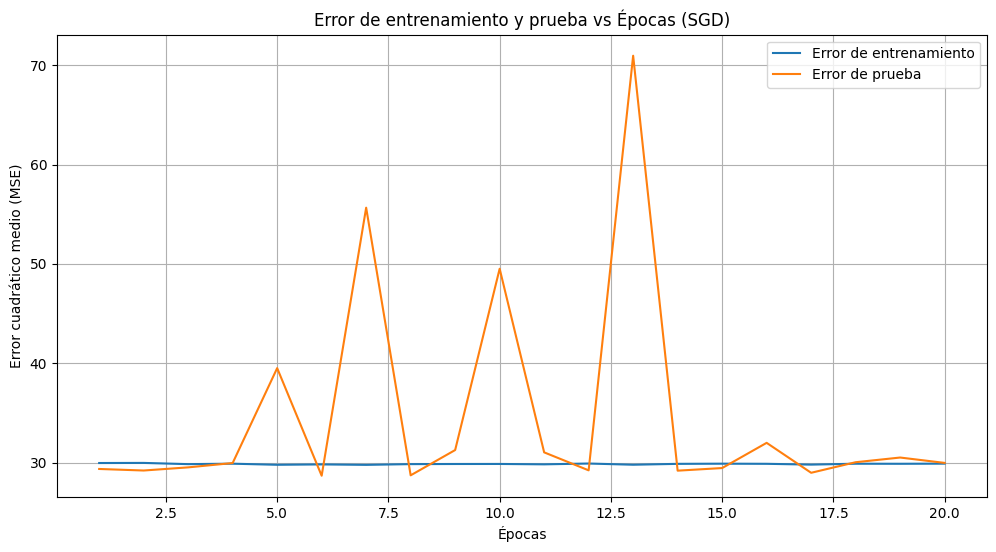

In [401]:
# Entrenamos el modelo
W_sgd = stochastic_gradient_descent(X_train_grad, y_train_grad, X_val_grad, y_val_grad, lr=0.01, epochs=20)

En este gráfico se observa el comportamiento del Gradiente Descendente Estocástico (SGD). A diferencia del Gradiente Descendente clásico, en este caso los pesos se actualizan tras cada muestra individual.

Esto hace que la curva de error presente pequeñas oscilaciones (ruido), sobre todo en los primeros momentos del entrenamiento. Sin embargo, la tendencia general muestra una convergencia estable y un error de entrenamiento bajo, lo que indica que el modelo logra aprender correctamente.

El error de prueba presenta algunos picos propios de la variabilidad de este método, pero se mantiene controlado. La tasa de aprendizaje elegida (lr = 0.001) demostró ser adecuada para estabilizar la curva.

In [404]:
# Agregar columna de unos a X_train y X_test para predicción
X_train_full_sgd = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test_full_sgd = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# Predicciones
y_train_pred_sgd = np.matmul(X_train_full_sgd, W_sgd)
y_test_pred_sgd = np.matmul(X_test_full_sgd, W_sgd)

# Métricas
r2_train_sgd = r2_score(y_train, y_train_pred_sgd)
r2_test_sgd = r2_score(y_test, y_test_pred_sgd)
rmse_train_sgd = np.sqrt(mean_squared_error(y_train, y_train_pred_sgd))
rmse_test_sgd = np.sqrt(mean_squared_error(y_test, y_test_pred_sgd))

print(f"R² (train): {r2_train_sgd:.4f} \tRMSE (train): {rmse_train_sgd:.4f}")
print(f"R² (test) : {r2_test_sgd:.4f} \tRMSE (test)  : {rmse_test_sgd:.4f}")

R² (train): 0.6977 	RMSE (train): 5.3255
R² (test) : 0.6934 	RMSE (test)  : 5.4020


## Gradiente Descendiente Mini-Batch

In [314]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Agregar columna de 1s para el término independiente
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Mezclar los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        total_batch_error = 0
        num_batches = 0

        for j in range(0, n, batch_size):
            # Obtener mini-batch
            x_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = x_batch @ W
            error = y_batch - prediction
            batch_mse = np.mean(error ** 2)
            total_batch_error += batch_mse
            num_batches += 1

            gradient = -2 * x_batch.T @ error / batch_size
            W = W - lr * gradient

        # Error promedio de entrenamiento por época
        train_errors.append(total_batch_error / num_batches)

        # Error de prueba (una vez por época)
        prediction_test = X_test @ W
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

    # Gráfico final
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), train_errors, label='Error de entrenamiento')
    plt.plot(range(1, epochs + 1), test_errors, label='Error de prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs Épocas (Mini-Batch GD)')
    plt.grid(True)
    plt.show()

    return W

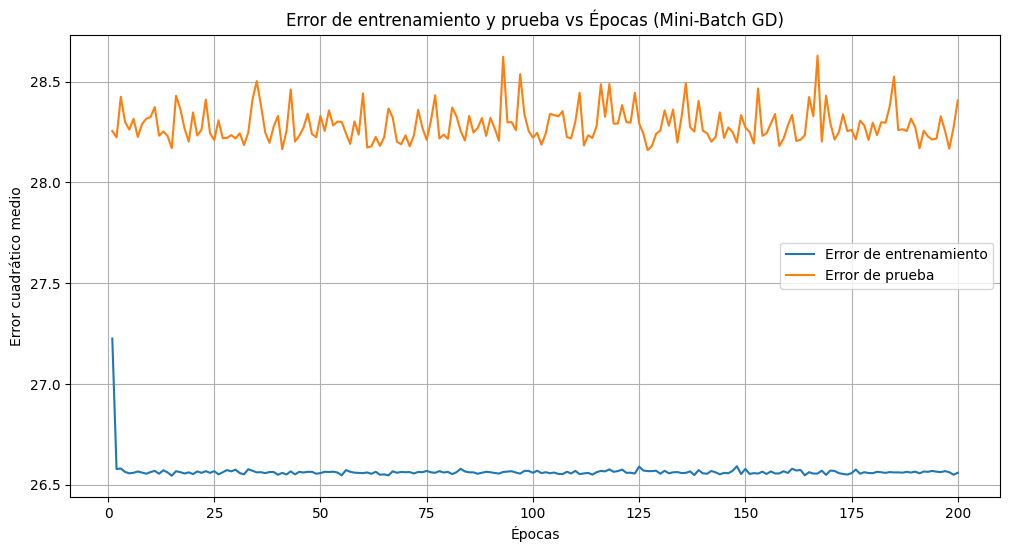

In [405]:
# Entrenamos el modelo
W_mbgd = mini_batch_gradient_descent(X_train_grad, y_train_grad, X_val_grad, y_val_grad, lr=0.005, epochs=200, batch_size=11)

En el método Gradiente Descendente Estocástico, a diferencia del Gradiente Descendente clásico, el error y los pesos se actualizan tras cada muestra, lo que suele generar un descenso más rápido pero con mayor variabilidad en la curva de error, como se observa en el gráfico de Error vs Época.

El método Gradiente Descendiente Mini-Batch es un punto intermedio entre ambos: en lugar de usar todo el dataset como GD o solo una muestra como en SGD, utiliza pequeños grupos de datos (batches) para actualizar los pesos, logrando un equilibrio entre estabilidad y velocidad de convergencia.

Cada método muestra comportamientos distintos:

GD es suave y estable, pero lento.

SGD es rápido pero ruidoso.

MBGD logra un balance óptimo, combinando rapidez y estabilidad.

Las curvas de error vs épocas mostraron cómo varía la estabilidad de cada método y permiten elegir la técnica adecuada según el contexto.

Al variar el hiperparámetro learning rate (lr) en los métodos de gradiente descendente, se observan comportamientos muy distintos:

Con valores altos como 0.1, el modelo aprende rápidamente pero puede volverse inestable, generando oscilaciones o incluso divergencia (particularmente en SGD).

Con valores bajos como 0.001, el aprendizaje es estable pero lento, y a veces el modelo no logra converger a una buena solución.

En nuestro caso, valores intermedios como 0.005 o 0.01 fueron los más efectivos, especialmente en Mini-Batch Gradient Descent, donde logramos un descenso suave del error y buena generalización.

In [406]:
# Agregar columna de unos a X_train y X_test para predicción
X_train_full_mbgd = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test_full_mbgd = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# Predicciones
y_train_pred_mbgd = np.matmul(X_train_full_mbgd, W_mbgd)
y_test_pred_mbgd = np.matmul(X_test_full_mbgd, W_mbgd)

# Métricas
r2_train_mbgd = r2_score(y_train, y_train_pred_mbgd)
r2_test_mbgd = r2_score(y_test, y_test_pred_mbgd)
rmse_train_mbgd = np.sqrt(mean_squared_error(y_train, y_train_pred_mbgd))
rmse_test_mbgd = np.sqrt(mean_squared_error(y_test, y_test_pred_mbgd))

print(f"R² (train): {r2_train_mbgd:.4f} \tRMSE (train): {rmse_train_mbgd:.4f}")
print(f"R² (test) : {r2_test_mbgd:.4f} \tRMSE (test)  : {rmse_test_mbgd:.4f}")

R² (train): 0.7134 	RMSE (train): 5.1852
R² (test) : 0.7108 	RMSE (test)  : 5.2468


## Regularización

### Ridge Regression

In [316]:
# Creación y entrenamiento del modelo.

RidgeModel = RidgeCV(
                           alphas          = np.logspace(-3, 6, 200),
                           fit_intercept   = True,
                           store_cv_values = True
                )

RidgeModel.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


RidgeCV(alphas=array([1.00000000e-03, 1.10975250e-03, 1.23155060e-03, 1.36671636e-03,
       1.51671689e-03, 1.68318035e-03, 1.86791360e-03, 2.07292178e-03,
       2.30043012e-03, 2.55290807e-03, 2.83309610e-03, 3.14403547e-03,
       3.48910121e-03, 3.87203878e-03, 4.29700470e-03, 4.76861170e-03,
       5.29197874e-03, 5.87278661e-03, 6.51733960e-03, 7.23263390e-03,
       8.02643352e-03, 8.90735464e-0...
       9.11588830e+04, 1.01163798e+05, 1.12266777e+05, 1.24588336e+05,
       1.38262217e+05, 1.53436841e+05, 1.70276917e+05, 1.88965234e+05,
       2.09704640e+05, 2.32720248e+05, 2.58261876e+05, 2.86606762e+05,
       3.18062569e+05, 3.52970730e+05, 3.91710149e+05, 4.34701316e+05,
       4.82410870e+05, 5.35356668e+05, 5.94113398e+05, 6.59318827e+05,
       7.31680714e+05, 8.11984499e+05, 9.01101825e+05, 1.00000000e+06]),
        store_cv_values=True)

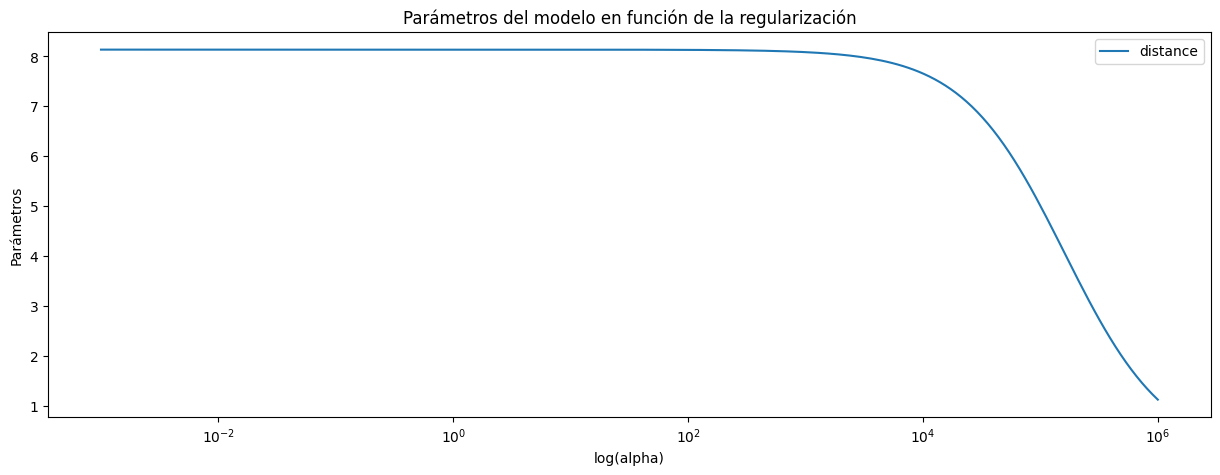

In [317]:
# Evolución de los parámetros en función de alpha

alphas = RidgeModel.alphas
coefs = []

for alpha in alphas:
    modelo_aux = Ridge(alpha=alpha)
    modelo_aux.fit(X_train_scaled, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train_scaled.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización')
plt.axis('tight')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


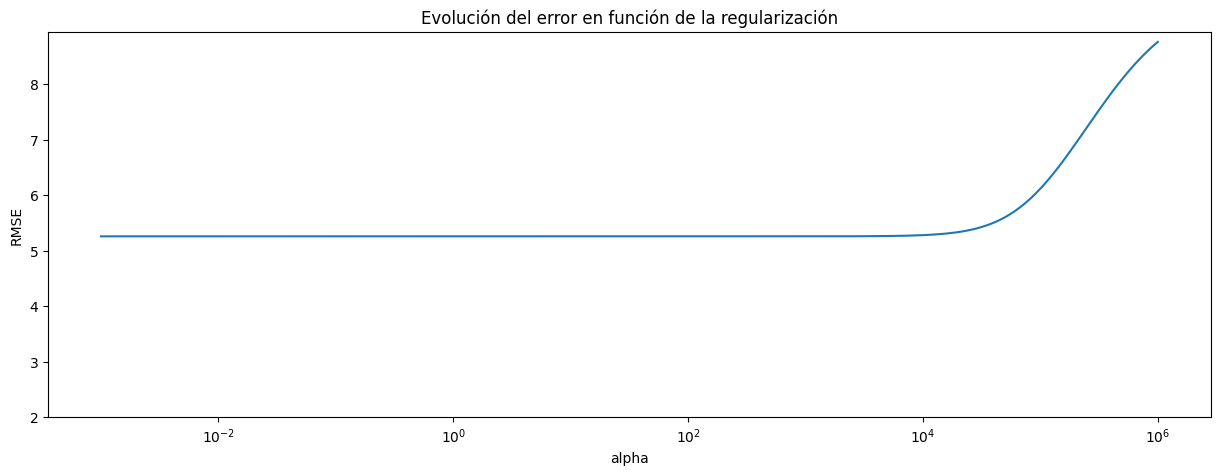

In [318]:
# Evolución del error de validación cruzada en función de alpha

# modelo.cv_values almacena el MSE de CV para cada valor de alpha.

mse_cv = RidgeModel.cv_values_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
rmse_ridge_train     = np.min(rmse_cv)
optimo       = RidgeModel.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(RidgeModel.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [319]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {RidgeModel.alpha_}")

Mejor valor de alpha encontrado: 1.3200884008314182


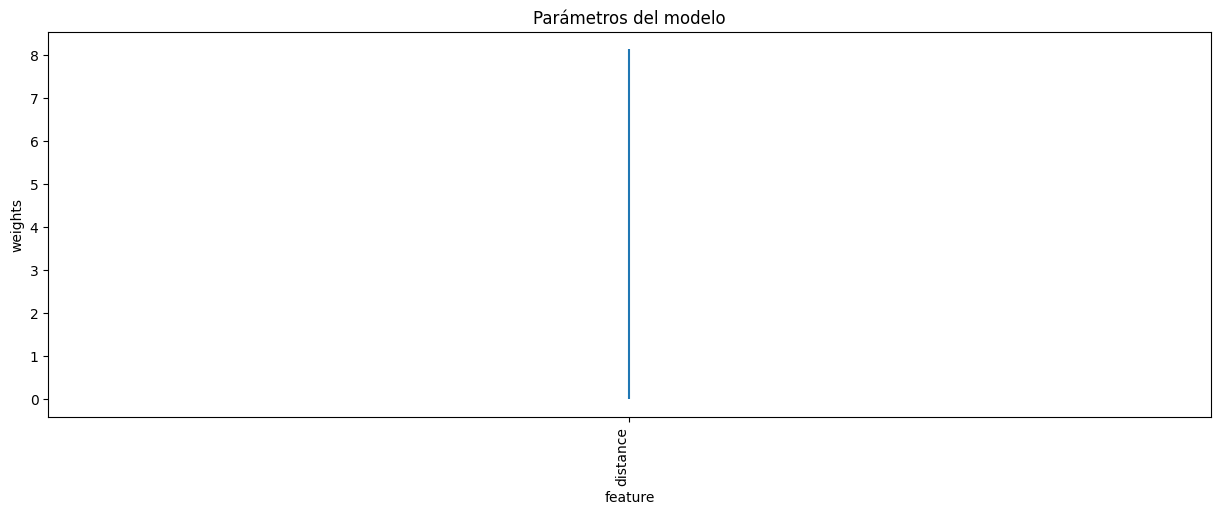

In [320]:
# Coeficientes del modelo

coeficientes_ModelRidge = pd.DataFrame({'predictor': X_train_scaled.columns,'coef': RidgeModel.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(coeficientes_ModelRidge.predictor, coeficientes_ModelRidge.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

In [321]:
# Predicciones test
y_predict_ridge = RidgeModel.predict(X_test_scaled)

In [322]:
# Error de test del modelo

mse_ridge_test = mean_squared_error(y_test, y_predict_ridge)
rmse_ridge_test = np.sqrt(mse_ridge_test)

print(f"El error (RMSE) de test es: {rmse_ridge_test:.2f}")

El error (RMSE) de test es: 5.33


In [323]:
r2_ridge_test = round(r2_score(y_test, y_predict_ridge),2)
r2_ridge_test

0.7

### Lasso Regression

In [324]:
LassoModel = LassoCV(
                           alphas          = np.logspace(-3, 6, 200),
                           fit_intercept   = True
                )

LassoModel.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-03, 1.10975250e-03, 1.23155060e-03, 1.36671636e-03,
       1.51671689e-03, 1.68318035e-03, 1.86791360e-03, 2.07292178e-03,
       2.30043012e-03, 2.55290807e-03, 2.83309610e-03, 3.14403547e-03,
       3.48910121e-03, 3.87203878e-03, 4.29700470e-03, 4.76861170e-03,
       5.29197874e-03, 5.87278661e-03, 6.51733960e-03, 7.23263390e-03,
       8.02643352e-03, 8.90735464e-0...
       9.11588830e+04, 1.01163798e+05, 1.12266777e+05, 1.24588336e+05,
       1.38262217e+05, 1.53436841e+05, 1.70276917e+05, 1.88965234e+05,
       2.09704640e+05, 2.32720248e+05, 2.58261876e+05, 2.86606762e+05,
       3.18062569e+05, 3.52970730e+05, 3.91710149e+05, 4.34701316e+05,
       4.82410870e+05, 5.35356668e+05, 5.94113398e+05, 6.59318827e+05,
       7.31680714e+05, 8.11984499e+05, 9.01101825e+05, 1.00000000e+06]))

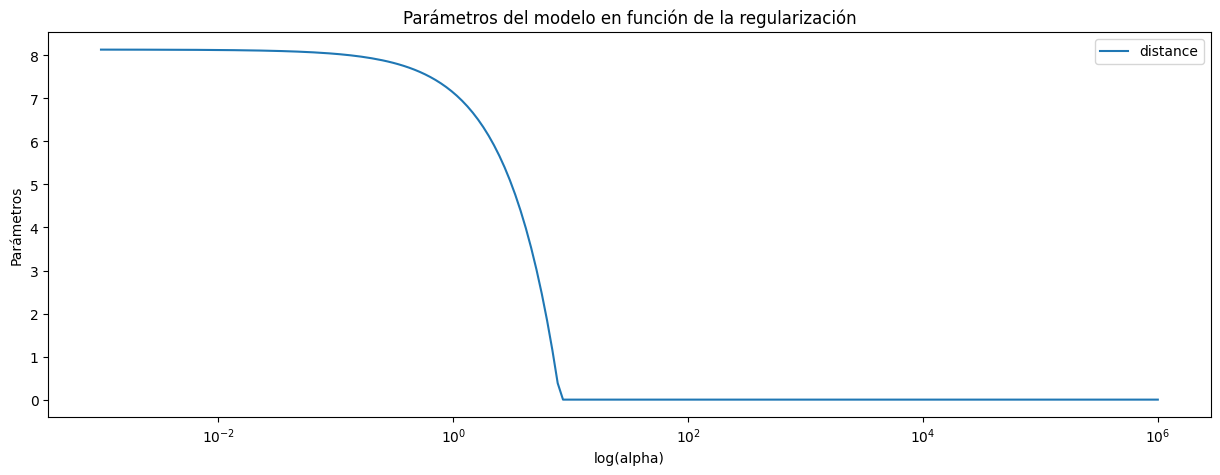

In [325]:
# Evolución de los parámetros en función de alpha

alphas = LassoModel.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(X_train_scaled, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train_scaled.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización')
plt.axis('tight')
plt.legend()
plt.show()


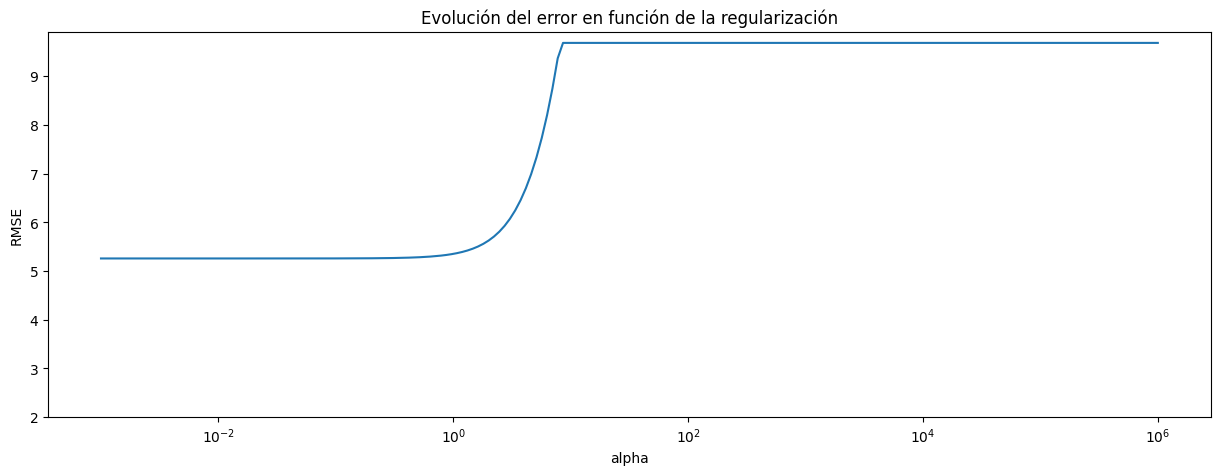

In [326]:
# Evolución del error de validación cruzada en función de alpha

# modelo.mse_path almacena el MSE de CV para cada valor de alpha.

mse_cv = LassoModel.mse_path_.mean(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
rmse_lasso_train     = np.min(rmse_cv)
optimo       = LassoModel.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(LassoModel.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [327]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {LassoModel.alpha_}")

Mejor valor de alpha encontrado: 0.001


In [328]:
coeficientes_Lasso = pd.DataFrame(
                        {'predictor': X_train_scaled.columns,
                         'coef': LassoModel.coef_.flatten()}
                  )


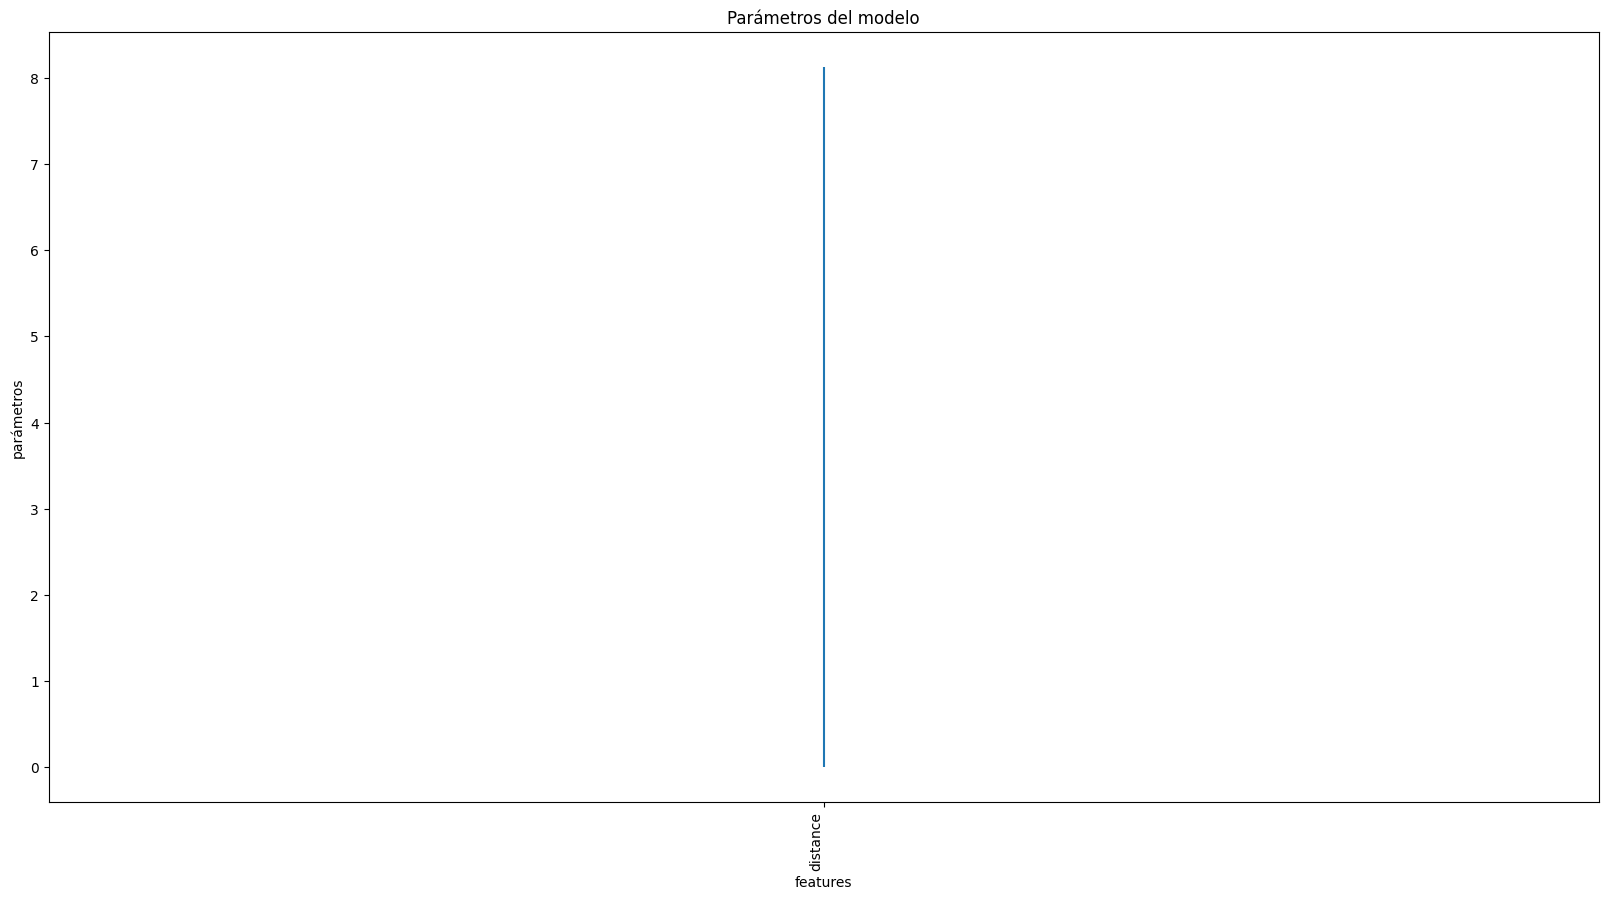

In [329]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(coeficientes_Lasso.predictor, coeficientes_Lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [330]:
y_pred_lasso = LassoModel.predict(X_test_scaled)

In [331]:
# Error de test del modelo

mse_lasso_test = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso_test = np.sqrt(mse_lasso_test)

print("")
print(f"El error (RMSE) de test es: {rmse_lasso_test:.2f}")


El error (RMSE) de test es: 5.33


In [332]:
r2_lasso_test = round(r2_score(y_test, y_pred_lasso),2)
r2_lasso_test

0.7

### ElasticNet


In [333]:
ElasticNetModel = ElasticNetCV(
                              l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas          = np.logspace(-3, 6, 200),
                              cv              = 10
                           )

ElasticNetModel.fit(X_train_scaled, y_train)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2064032.2120730344, tolerance: 1358.0135203521338
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2057149.915355649, tolerance: 1358.0135203521338
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/l

ElasticNetCV(alphas=array([1.00000000e-03, 1.10975250e-03, 1.23155060e-03, 1.36671636e-03,
       1.51671689e-03, 1.68318035e-03, 1.86791360e-03, 2.07292178e-03,
       2.30043012e-03, 2.55290807e-03, 2.83309610e-03, 3.14403547e-03,
       3.48910121e-03, 3.87203878e-03, 4.29700470e-03, 4.76861170e-03,
       5.29197874e-03, 5.87278661e-03, 6.51733960e-03, 7.23263390e-03,
       8.02643352e-03, 8.907354...
       9.11588830e+04, 1.01163798e+05, 1.12266777e+05, 1.24588336e+05,
       1.38262217e+05, 1.53436841e+05, 1.70276917e+05, 1.88965234e+05,
       2.09704640e+05, 2.32720248e+05, 2.58261876e+05, 2.86606762e+05,
       3.18062569e+05, 3.52970730e+05, 3.91710149e+05, 4.34701316e+05,
       4.82410870e+05, 5.35356668e+05, 5.94113398e+05, 6.59318827e+05,
       7.31680714e+05, 8.11984499e+05, 9.01101825e+05, 1.00000000e+06]),
             cv=10, l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99])

In [334]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = ElasticNetModel.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
ElasticNetModel_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [ElasticNetModel.l1_ratio, ElasticNetModel.alphas_],
                                    names     = ['l1_ratio', 'ElasticNetModel.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

ElasticNetModel_resultados_cv['rmse_cv'] = np.sqrt(ElasticNetModel_resultados_cv['mse_cv'])
rmse_elastic_train = ElasticNetModel_resultados_cv['rmse_cv'].min()
ElasticNetModel_resultados_cv = ElasticNetModel_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
ElasticNetModel_resultados_cv

,l1_ratio,ElasticNetModel.alphas_,mse_cv,rmse_cv
1399,0.99,0.001000,27.652439,5.258559
1398,0.99,0.001110,27.652439,5.258559
1397,0.99,0.001232,27.652439,5.258559
1199,0.95,0.001000,27.652439,5.258559
1396,0.99,0.001367,27.652440,5.258559
...,...,...,...,...
204,0.10,659318.827133,93.808212,9.685464
203,0.10,731680.714343,93.808212,9.685464
202,0.10,811984.499318,93.808212,9.685464
201,0.10,901101.825167,93.808212,9.685464


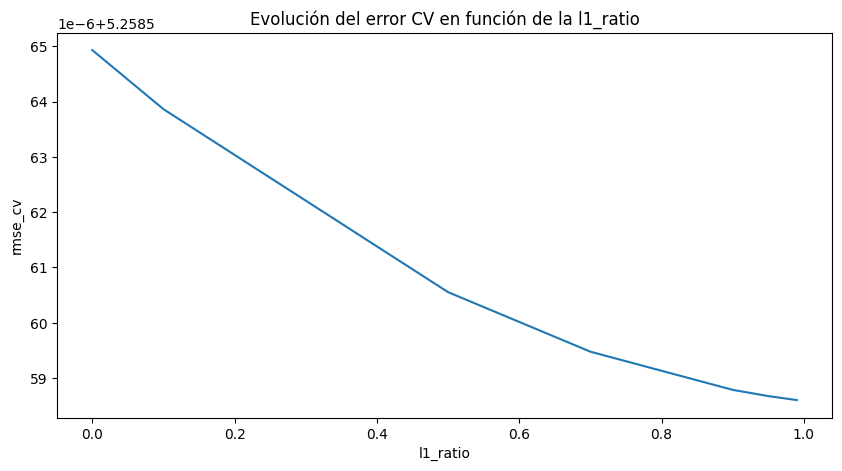

In [335]:
fig, ax = plt.subplots(figsize=(10, 5))
ElasticNetModel_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [336]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {ElasticNetModel.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {ElasticNetModel.l1_ratio_}")

Mejor valor de alpha encontrado: 0.001
Mejor valor de l1_ratio encontrado: 0.99


In [337]:
# Parámetros del modelo
coeficientes_ElasticNet = pd.DataFrame(
                        {'predictor': X_train_scaled.columns,
                         'coef': ElasticNetModel.coef_.flatten()}
                  )

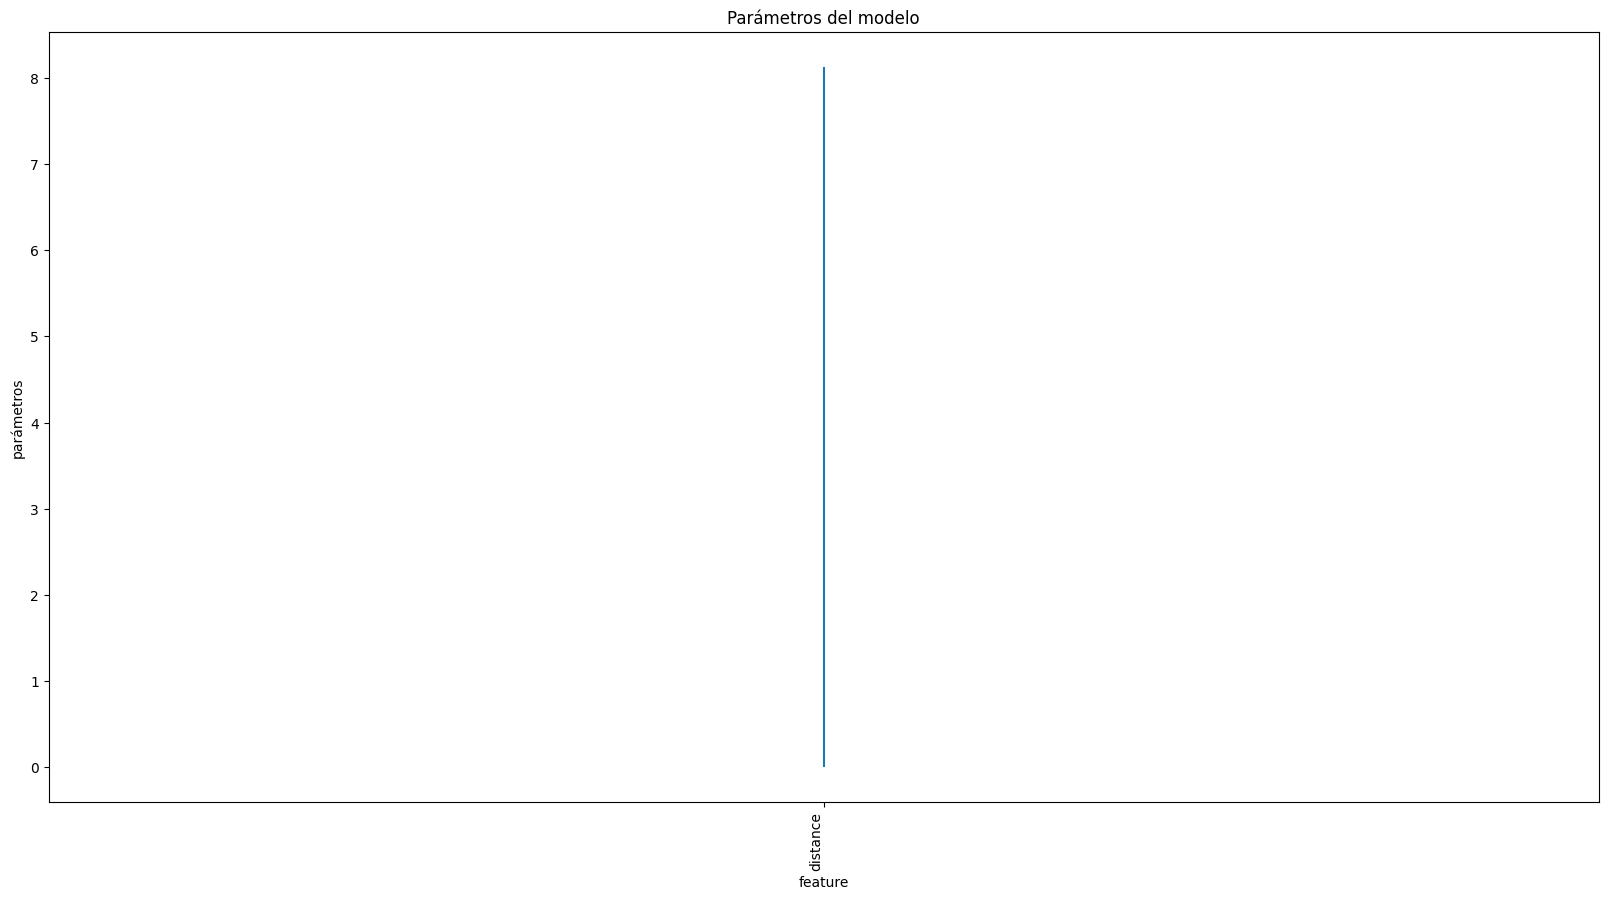

In [338]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(coeficientes_ElasticNet.predictor, coeficientes_ElasticNet.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [339]:
# Predicciones test
y_pred_elastic = ElasticNetModel.predict(X_test_scaled)

In [340]:
# Error de test del modelo

mse_elastic_test = mean_squared_error(y_test, y_pred_elastic)
rmse_elastic_test = np.sqrt(mse_elastic_test)

print("")
print(f"El error (RMSE) de test es: {rmse_elastic_test:.2f}")


El error (RMSE) de test es: 5.33


In [341]:
r2_elastic_test = round(r2_score(y_test, y_pred_elastic),2)
r2_elastic_test

0.7

In [342]:
#RESTA VER POR QUE DAN ERROR EL CALCULO DE LOS ERRORES TEST DE LOS 3 MODELOS. VER SI ES MEJOR EL SISTEMA DE ENTRENAMIENTO CON TODAS LAS VARIABLES, PARA VISUALIZAR MEJOR LOS GRAFICOS.

## Comparación entre modelos y Conclusión

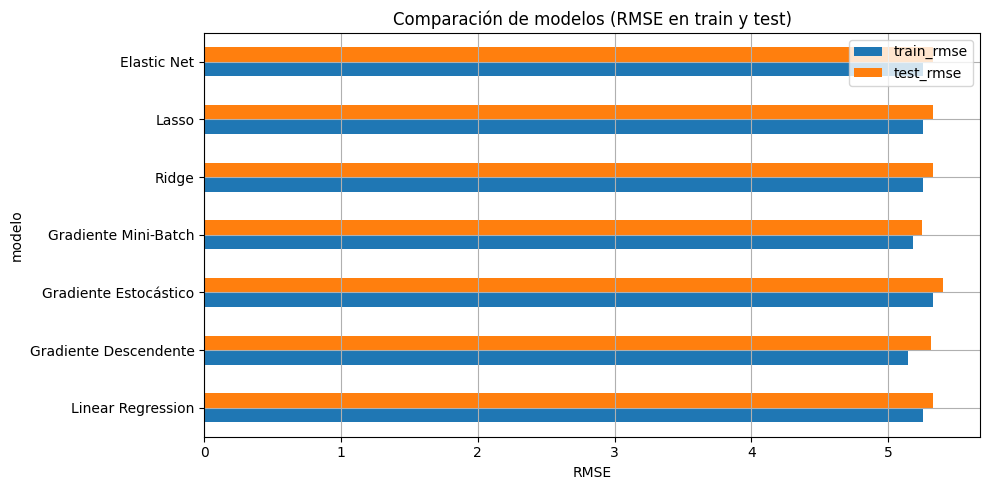

In [411]:
df_comparacion = pd.DataFrame({
    'modelo': [
        'Linear Regression',
        'Gradiente Descendente',
        'Gradiente Estocástico',
        'Gradiente Mini-Batch',
        'Ridge',
        'Lasso',
        'Elastic Net'
    ],
    'train_rmse': [
        rmse_lineal_train1,
        rmse_train_gd,
        rmse_train_sgd,
        rmse_train_mbgd,
        rmse_ridge_train,
        rmse_lasso_train,
        rmse_elastic_train
    ],
    'test_rmse': [
        rmse_lineal_test1,
        rmse_val_gd,
        rmse_test_sgd,
        rmse_test_mbgd,
        rmse_ridge_test,
        rmse_lasso_test,
        rmse_elastic_test
    ]
})

# Gráfico comparativo
fig, ax = plt.subplots(figsize=(10, 5))
df_comparacion.set_index('modelo')[['train_rmse', 'test_rmse']].plot(kind='barh', ax=ax)
ax.set_xlabel('RMSE')
ax.set_title('Comparación de modelos (RMSE en train y test)')
plt.grid(True)
plt.tight_layout()
plt.show()